In [ ]:
!pip install urllib2

ERROR: Could not find a version that satisfies the requirement urllib2 (from versions: none)
ERROR: No matching distribution found for urllib2


In [ ]:
import pandas as pd
import io
import requests
url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
c

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [ ]:
len(c)

3650

In [ ]:

batch_size=5
data=(torch.zeros((int(len(c)/batch_size)),batch_size))
#X=(torch.zeros((int(len(c)/batch_size)),batch_size))
count=0
for k,l in enumerate(c["Temp"]):#india_covid_date["Confirmed"]):
  if(k%batch_size==0 and k>0):
    count+=1
  if(count>=(int(len(c)/batch_size))):
    break
  data[count,k%batch_size]=(l)
  #X[count,k%batch_size]=int(k)

In [ ]:
data.shape

torch.Size([730, 5])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:

def a_norm(Q, K):
    m = torch.matmul(Q, K.transpose(2,1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())
    
    return torch.softmax(m , -1) ### shape after  this is [15,6,6]


def attention(Q, K, V):
    #Attention(Q, K, V) = norm(QK)V
    a = a_norm(Q, K) #(batch_size, dim_attn, seq_length)
   # print(f"a_norm {a.shape}")
   # print(f"attention +{torch.matmul(a,  V).shape}")
    
    return  torch.matmul(a,  V) #(batch_size, seq_length, seq_length) ##shape is[15,6,10]

class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn):
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val)
        self.key = Key(dim_val, dim_attn)
        self.query = Query(dim_val, dim_attn)
    
    def forward(self, x, kv = None):
        if(kv is None):
            #Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        
        #Attention with x as Q, external vector kv as K an V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.heads = nn.ModuleList(self.heads)
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
        
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
        #print(f"shape before Multihead {a.shape}")
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        #print(f"shape after Multihead+{a.shape}")
        x = self.fc(a)
        #print(f"shape after  linear layer in Multihead+{x.shape}")
        
        
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.dim_val = dim_val
        
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False)
        #self.fc2 = nn.Linear(5, dim_val)
    
    def forward(self, x):
        x = self.fc1(x)
        #print(f"Value-+{x.shape}")
        #x = self.fc2(x)
        
        return x

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        x = self.fc1(x)
        #print(f"Key-{x.shape}")
        #x = self.fc2(x)
        
        return x

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        #print(f"beforeQuery-{x.shape}")
        x = self.fc1(x)
        #print(f"Query-{x.shape}")
        #print(x.shape)
        #x = self.fc2(x)
        
        return x

# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)                  ####doubt- what is this???

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]. squeeze(1)
        return x     
    
def get_data(batch_size, input_sequence_length, output_sequence_length):
    i = input_sequence_length + output_sequence_length
    t = torch.zeros(batch_size,1).uniform_(0,20 - i).int()
   # print(f"t {t}")
    b = torch.arange(-10, -10 + i).unsqueeze(0).repeat(batch_size,1) + t
    #print(f"b before {torch.arange(-10, -10 + i).unsqueeze(0).repeat(batch_size,1)}")#### 1st part of above b
    #print(f"b after {b}")
    s = torch.sigmoid(b.float())
    #print(f"s {s}")
    return s[:, :input_sequence_length].unsqueeze(-1), s[:,-output_sequence_length:]

In [ ]:

class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, dim_attn , n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
    
    def forward(self, x):
        #print("---------------ENCODER STARTING-------------------")
        a = self.attn(x)
        x = self.norm1(x + a)
        
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm2(x + a)
       # print(f"End Of Encoder shape{x.shape}")
        
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        
    def forward(self, x, enc):
       # print("---------------DECODER STARTING-------------------")
       # print(f"Start of decoder shape {x.shape}") 
        a = self.attn1(x)
        x = self.norm1(a + x)
       # print(f"Mid decoder shaper after 1st Attention and Normalization{x.shape}")
        a = self.attn2(x, kv = enc)
        x = self.norm2(a + x)
       # print(f"After 2nd Attention Decoder(Mixed Attention)")
        
        a = self.fc1(F.elu(self.fc2(x)))
        
        x = self.norm3(x + a)
        #print(f"End of decoder shape {x.shape}")
        return x

class Transformer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, dec_seq_len, out_seq_len, n_decoder_layers = 1, n_encoder_layers = 1, n_heads = 1):
        super(Transformer, self).__init__()
        self.dec_seq_len = dec_seq_len
        
        #Initiate encoder and Decoder layers
        self.encs = []
        for i in range(n_encoder_layers):
            self.encs.append(EncoderLayer(dim_val, dim_attn, n_heads))
        
        self.decs = []
        for i in range(n_decoder_layers):
            self.decs.append(DecoderLayer(dim_val, dim_attn, n_heads))
        
        self.pos = PositionalEncoding(dim_val)
        
        #Dense layers for managing network inputs and outputs
        self.enc_input_fc = nn.Linear(input_size, dim_val)
        self.dec_input_fc = nn.Linear(input_size, dim_val)
        self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)
    
    def forward(self, x):
        #encoder
        #print(f"after positional encoding shape{self.pos(self.enc_input_fc(x))}")
        e = self.encs[0](self.pos(self.enc_input_fc(x)))
        for enc in self.encs[1:]:
            e = enc(e)               ##### this means we are using output of  before for next n-head encoder
        
        #decoder
        d = self.decs[0](self.dec_input_fc(x[:,-self.dec_seq_len:]), e)
        for dec in self.decs[1:]:
            d = dec(d, e)                  ###How to see the Loss that way???
            
            
        #output
        x = self.out_fc(d.flatten(start_dim=1))
        return x

In [ ]:
enc_seq_len = 4
dec_seq_len = 2
output_sequence_length = 1

dim_val = 10
dim_attn =5
lr = 0.001
epochs = 150
n_heads = 1
n_decoder_layers = 1
n_encoder_layers = 1

batch_size =5

#init network and optimizer
t = Transformer(dim_val, dim_attn, 1,dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []

In [ ]:
X_false,Y_false=get_data(5,4,1)

In [ ]:
X_false.shape

torch.Size([5, 4, 1])

In [ ]:
X=data[:, :enc_seq_len].unsqueeze(-1)
Y=data[:,-output_sequence_length:]

In [ ]:
data

tensor([[20.7000, 17.9000, 18.8000, 14.6000, 15.8000],
        [15.8000, 15.8000, 17.4000, 21.8000, 20.0000],
        [16.2000, 13.3000, 16.7000, 21.5000, 25.0000],
        ...,
        [13.9000, 17.2000, 14.7000, 15.4000, 13.1000],
        [13.2000, 13.9000, 10.0000, 12.9000, 14.6000],
        [14.0000, 13.6000, 13.5000, 15.7000, 13.0000]])

In [ ]:
X.shape

torch.Size([730, 4, 1])

In [ ]:
X[0:5,:,:].shape

torch.Size([5, 4, 1])

In [ ]:
Y[0:5,:]

tensor([[15.8000],
        [20.0000],
        [25.0000],
        [15.5000],
        [16.5000]])

Streaming output truncated to the last 5000 lines.
---------
4.0521745681762695@6
---------
4.292446136474609@6
---------
5.39731502532959@6
---------
5.123986721038818@6
---------
4.436612129211426@6
---------
5.59343147277832@6
---------
7.578962802886963@6
---------
5.765521049499512@6
---------
8.386068344116211@6
---------
6.8032660484313965@6
---------
9.088988304138184@6
---------
6.9240827560424805@6
---------
8.520132064819336@6
---------
10.782158851623535@6
---------
12.593484878540039@6
---------
10.12336254119873@6
---------
9.755188941955566@6
---------
7.990877628326416@6
---------
3.564417600631714@6
---------
1.6622505187988281@6
---------
0.7499522566795349@6
---------
0.9005371332168579@6
---------
3.2395167350769043@6
---------
6.7004289627075195@6
---------
6.586433410644531@6
---------
6.7376203536987305@6
---------
10.60888671875@6
---------
9.599835395812988@6
---------
6.010226726531982@6
---------
6.6036553382873535@6
---------
6.56154727935791@6
---------
2.4

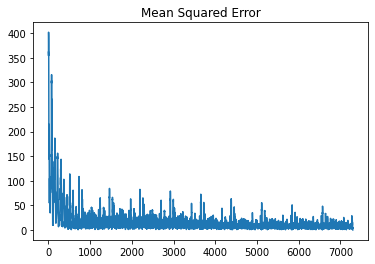

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for epoch in range(10):  
  #data=(torch.zeros((int(data_list[i].shape[0]/batch_size)),batch_size))
        #X=(torch.zeros((int(data_list[i].shape[0]/batch_size)),batch_size))
  #count=0
  for i in range(X.shape[0]):
    #india_covid_date["Confirmed"]): 
    #loss_O=nn.L1Loss(reduction="mean")
    X_final=X[i:i+5,:,:]
    Y_final=Y[i:i+5,:]
    out=[]w
    optimizer.zero_grad()
            ##X, Y = get_data(batch_size, enc_seq_len, output_sequence_length)
            #print(X)
            #Forward pass and calculate loss
    print("---------")
    net_out = t(X_final)
            #print(net_out.shape,Y.shape)
    loss = torch.mean((net_out-Y_final)**2)
            #backwards pass
    loss.backward()
    optimizer.step()
            #Track losses and draw rgaph
    out.append([net_out.detach().numpy(), Y])
    losses.append(loss)
    ax.clear()
    ax.plot(losses)
    ax.set_title("Mean Squared Error")
    fig.canvas.draw()
    print(f"{loss}@{epoch}")

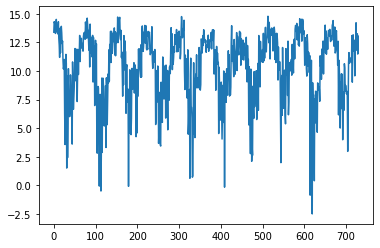

In [ ]:
plt.plot(t(X).detach().numpy())

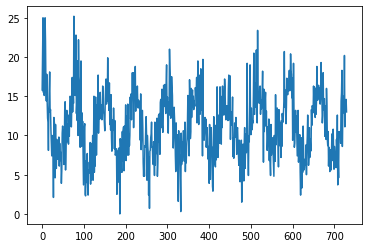

In [ ]:
plt.plot(Y.squeeze().numpy())

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
torch.save(t,f"/content/drive/My Drive/transformer.pth")

FileNotFoundError: ignored